In [9]:
from src.data import load_cache_entry, cache_path
from src.config import config
from collections import Counter, defaultdict

LEAGUE_ID = config.league_id
YEARS = config.years
DEFAULT_VIEWS = ["mRoster", "mTeam"]

print("League:", LEAGUE_ID)
print("Years:", YEARS)


League: 1283828
Years: [2025, 2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015]


In [100]:
def get_roster_for_period(league_id, year, period, views=("mMatchup","mTeam")):
    """
    Extract rosters for a given year/period.

    Returns
    -------
    { teamId: { 
        "rostered": [(playerId, fullName)],   # full weekly roster (bench + starters)
        "starters": [(playerId, fullName)]    # starters only
      } }
    """
    data = load_cache_entry(league_id, year, period, list(views))
    if not data or "schedule" not in data:
        return {}

    rosters = {}

    for row in data.get("schedule", []):
        if row.get("matchupPeriodId") != period:
            continue

        for side in ("home", "away"):
            team = row.get(side)
            if not team:
                continue

            team_id = team["teamId"]

            # Full roster for this scoring period (bench + starters)
            rostered_entries = team.get("rosterForCurrentScoringPeriod", {}).get("entries", [])

            # Starters for this scoring period (active lineup)
            starters_entries = team.get("rosterForMatchupPeriod", {}).get("entries", [])

            rostered = []
            for entry in rostered_entries:
                player = entry.get("playerPoolEntry", {}).get("player", {})
                pid, name = player.get("id"), player.get("fullName")
                if pid and name:
                    rostered.append((pid, name))

            starters = []
            for entry in starters_entries:
                player = entry.get("playerPoolEntry", {}).get("player", {})
                pid, name = player.get("id"), player.get("fullName")
                if not pid or not name:
                    continue
                # ESPN bench/IR are typically 20/21; keeping this filter in case it's present
                if entry.get("lineupSlotId") not in (20, 21):
                    starters.append((pid, name))

            rosters[team_id] = {"rostered": rostered, "starters": starters}

    return rosters

# ---- Quick sanity test ----
year, period = 2021, 13
rosters = get_roster_for_period(LEAGUE_ID, year, period)
print("Teams found:", len(rosters))
for tid, info in list(rosters.items())[:]:
    print(f"Team {tid}: rostered={len(info['rostered'])}, starters={len(info['starters'])}")
    print("Rostered sample:", info['rostered'][:])
    print("Starters sample:", info['starters'][:])


Teams found: 12
Team 10: rostered=15, starters=9
Rostered sample: [(3054850, 'Alvin Kamara'), (2576925, 'Darren Waller'), (3932905, 'Diontae Johnson'), (4239993, 'Tee Higgins'), (4052042, 'James Robinson'), (12483, 'Matthew Stafford'), (-16006, 'Cowboys D/ST'), (3975763, 'Greg Joseph'), (13934, 'Antonio Brown'), (4569173, 'Rhamondre Stevenson'), (16777, 'Carlos Hyde'), (3843945, 'Foster Moreau'), (3115378, 'Russell Gage'), (3128721, 'Sony Michel'), (2576623, 'DeVante Parker')]
Starters sample: [(3843945, 'Foster Moreau'), (12483, 'Matthew Stafford'), (-16006, 'Cowboys D/ST'), (3932905, 'Diontae Johnson'), (4052042, 'James Robinson'), (4239993, 'Tee Higgins'), (3115378, 'Russell Gage'), (3128721, 'Sony Michel'), (3975763, 'Greg Joseph')]
Team 7: rostered=15, starters=9
Rostered sample: [(3116593, 'Dalvin Cook'), (3040151, 'George Kittle'), (4035538, 'David Montgomery'), (2977187, 'Cooper Kupp'), (13982, 'Julio Jones'), (8439, 'Aaron Rodgers'), (3115364, 'Leonard Fournette'), (4048244, '

In [ ]:
def count_player_usage(league_id, years, owners=None, max_periods=20):
    """
    Count weeks rostered vs started using playerId as key.
    Returns { teamId: { "rostered": Counter, "starters": Counter }, "names": {pid: name} }
    """
    from collections import defaultdict, Counter
    usage = defaultdict(lambda: {"rostered": Counter(), "starters": Counter()})
    id_to_name = {}

    for year in years:
        for period in range(1, max_periods + 1):
            rosters = get_roster_for_period(league_id, year, period)
            for team_id, info in rosters.items():
                if owners and team_id not in owners:
                    continue
                for pid, name in info["rostered"]:
                    usage[team_id]["rostered"][pid] += 1
                    id_to_name[pid] = name
                for pid, name in info["starters"]:
                    usage[team_id]["starters"][pid] += 1
                    id_to_name[pid] = name

    return usage, id_to_name

# ---- Unit Test ----
counts, id_to_name = count_player_usage(LEAGUE_ID, years=[2024])
print("Teams counted:", len(counts))
for tid, counters in list(counts.items())[:2]:
    print(f"\nTeam {tid} top 3 rostered:")
    for pid, cnt in counters["rostered"].most_common(3):
        print("   ", id_to_name[pid], cnt)
    print("Top 3 starters:")
    for pid, cnt in counters["starters"].most_common(3):
        print("   ", id_to_name[pid], cnt)


Teams counted: 1

Team 2 top 3 rostered:
    Christian McCaffrey 17
    A.J. Brown 17
    Justin Jefferson 17
    Chris Godwin 17
    Logan Thomas 17
    Russell Wilson 17
    Nyheim Hines 17
    Michael Pittman Jr. 17
    T.Y. Hilton 17
    Steelers D/ST 17
    Mason Crosby 14
    Mark Ingram II 13
    Sam Darnold 13
    Curtis Samuel 11
    Cameron Brate 7
    Dalton Schultz 6
    Devonta Freeman 6
    DJ Chark Jr. 4
    Josh Lambo 4
    Alexander Mattison 4
    David Johnson 3
Top 3 starters:
    Nyheim Hines 16
    Steelers D/ST 16
    Justin Jefferson 16
    Chris Godwin 14
    Mason Crosby 13
    Russell Wilson 11
    A.J. Brown 10
    Mark Ingram II 7
    Michael Pittman Jr. 6
    Cameron Brate 6
    Dalton Schultz 6
    Christian McCaffrey 4
    Logan Thomas 4
    Sam Darnold 4
    Josh Lambo 3
    Alexander Mattison 1


In [89]:
from collections import Counter
from datetime import datetime

def count_player_usage_spanning_seasons(
    league_id,
    years,
    team_id,
    max_periods=20,
    current_week_cap=None,
):
    """
    Aggregate player usage (rostered vs starters) across multiple seasons
    for a given teamId, using playerId for stable keys.

    Returns:
      usage_all : { "rostered": Counter, "starters": Counter }
      id_to_name : { playerId: lastSeenFullName }
    """
    usage_all = {"rostered": Counter(), "starters": Counter()}
    id_to_name = {}
    current_year = datetime.now().year

    for year in years:
        limit = max_periods
        if current_week_cap and year == current_year:
            limit = min(limit, current_week_cap)

        usage, names = count_player_usage(
            league_id,
            years=[year],
            owners=[team_id],
            max_periods=limit,
        )
        if team_id not in usage:
            continue

        usage_all["rostered"].update(usage[team_id]["rostered"])
        usage_all["starters"].update(usage[team_id]["starters"])
        id_to_name.update(names)

    return usage_all, id_to_name


# ---- Unit Test ----
team_id = 1
years_to_check = list(range(2018,2026))#[2024,2025]
current_week_cap = 2  # cap current year

usage_spanning, names = count_player_usage_spanning_seasons(
    LEAGUE_ID,
    years=years_to_check,
    team_id=team_id,
    max_periods=20,
    current_week_cap=current_week_cap,
)

year_label = f"{min(years_to_check)}–{max(years_to_check)}" if len(years_to_check) > 1 else str(years_to_check[0])
print(f"=== Team {team_id} spanning {year_label} ===")

print("Top 5 rostered:")
for pid, cnt in usage_spanning["rostered"].most_common(5):
    print("   ", names.get(pid, pid), cnt)

print("Top 5 starters:")
for pid, cnt in usage_spanning["starters"].most_common(5):
    print("   ", names.get(pid, pid), cnt)


=== Team 1 spanning 2018–2025 ===
Top 5 rostered:
    Chris Godwin 60
    Mark Andrews 52
    Aaron Jones Sr. 43
    Raheem Mostert 43
    CeeDee Lamb 34
Top 5 starters:
    Mark Andrews 42
    Chris Godwin 40
    CeeDee Lamb 30
    Raheem Mostert 28
    David Montgomery 26


In [101]:
from src.analysis import build_owner_lookup
from src.data import load_cache_entry

def top_players_per_owner(
    league_id,
    years,
    n=5,
    max_periods=20,
    current_week_cap=None,
    include_starters=True,
):
    """
    For each owner, list their top-N rostered (and optionally starters)
    across the given timeframe.
    """
    # Grab one cached dataset to resolve teamId → ownerName
    latest_year = max(years)
    sample_data = load_cache_entry(league_id, latest_year, 1, ["mMatchup", "mTeam"])
    owner_lookup = build_owner_lookup(sample_data)

    results = {}
    for team_id in owner_lookup.keys():
        usage_spanning, names = count_player_usage_spanning_seasons(
            league_id,
            years=years,
            team_id=team_id,
            max_periods=max_periods,
            current_week_cap=current_week_cap,
        )
        results[team_id] = (usage_spanning, names)

    # ---- Pretty Print ----
    year_label = f"{min(years)}–{max(years)}" if len(years) > 1 else str(years[0])
    for team_id, (usage, names) in results.items():
        owner = owner_lookup.get(team_id, f"Team {team_id}")
        print(f"\n=== {owner} ({year_label}) ===")

        print("Top rostered:")
        for pid, cnt in usage["rostered"].most_common(n):
            print(f"   {names.get(pid, pid)}: {cnt}")

        if include_starters:
            print("Top starters:")
            for pid, cnt in usage["starters"].most_common(n):
                print(f"   {names.get(pid, pid)}: {cnt}")

    return results



# ---- Unit Test ----
years_to_check = list(range(2018,2026))#[2024,2025]
res = top_players_per_owner(
    LEAGUE_ID,
    years=years_to_check,
    n=10,
    max_periods=20,
    current_week_cap=2,  # cap current season at week 2
)



=== Ferrara (2018–2025) ===
Top rostered:
   Chris Godwin: 60
   Mark Andrews: 52
   Aaron Jones Sr.: 43
   Raheem Mostert: 43
   CeeDee Lamb: 34
   Odell Beckham Jr.: 32
   Robby Anderson: 32
   David Montgomery: 32
   Cowboys D/ST: 30
   Tom Brady: 26
Top starters:
   Mark Andrews: 42
   Chris Godwin: 40
   CeeDee Lamb: 30
   Raheem Mostert: 28
   David Montgomery: 26
   Odell Beckham Jr.: 25
   Aaron Jones Sr.: 25
   Cowboys D/ST: 25
   Tom Brady: 18
   Dalvin Cook: 16

=== Tanner (2018–2025) ===
Top rostered:
   Mason Crosby: 57
   Aaron Rodgers: 49
   Russell Wilson: 34
   Brandin Cooks: 33
   Christian McCaffrey: 33
   Marquise Brown: 33
   Jerry Jeudy: 33
   Mike Evans: 30
   Mark Ingram II: 29
   Justin Jefferson: 29
Top starters:
   Mason Crosby: 56
   Aaron Rodgers: 29
   Justin Jefferson: 27
   Aaron Jones: 27
   Mike Evans: 25
   Mark Ingram II: 22
   Broncos D/ST: 21
   Davante Adams: 20
   Marquise Brown: 20
   Steelers D/ST: 19

=== Matz (2018–2025) ===
Top rostered:
  

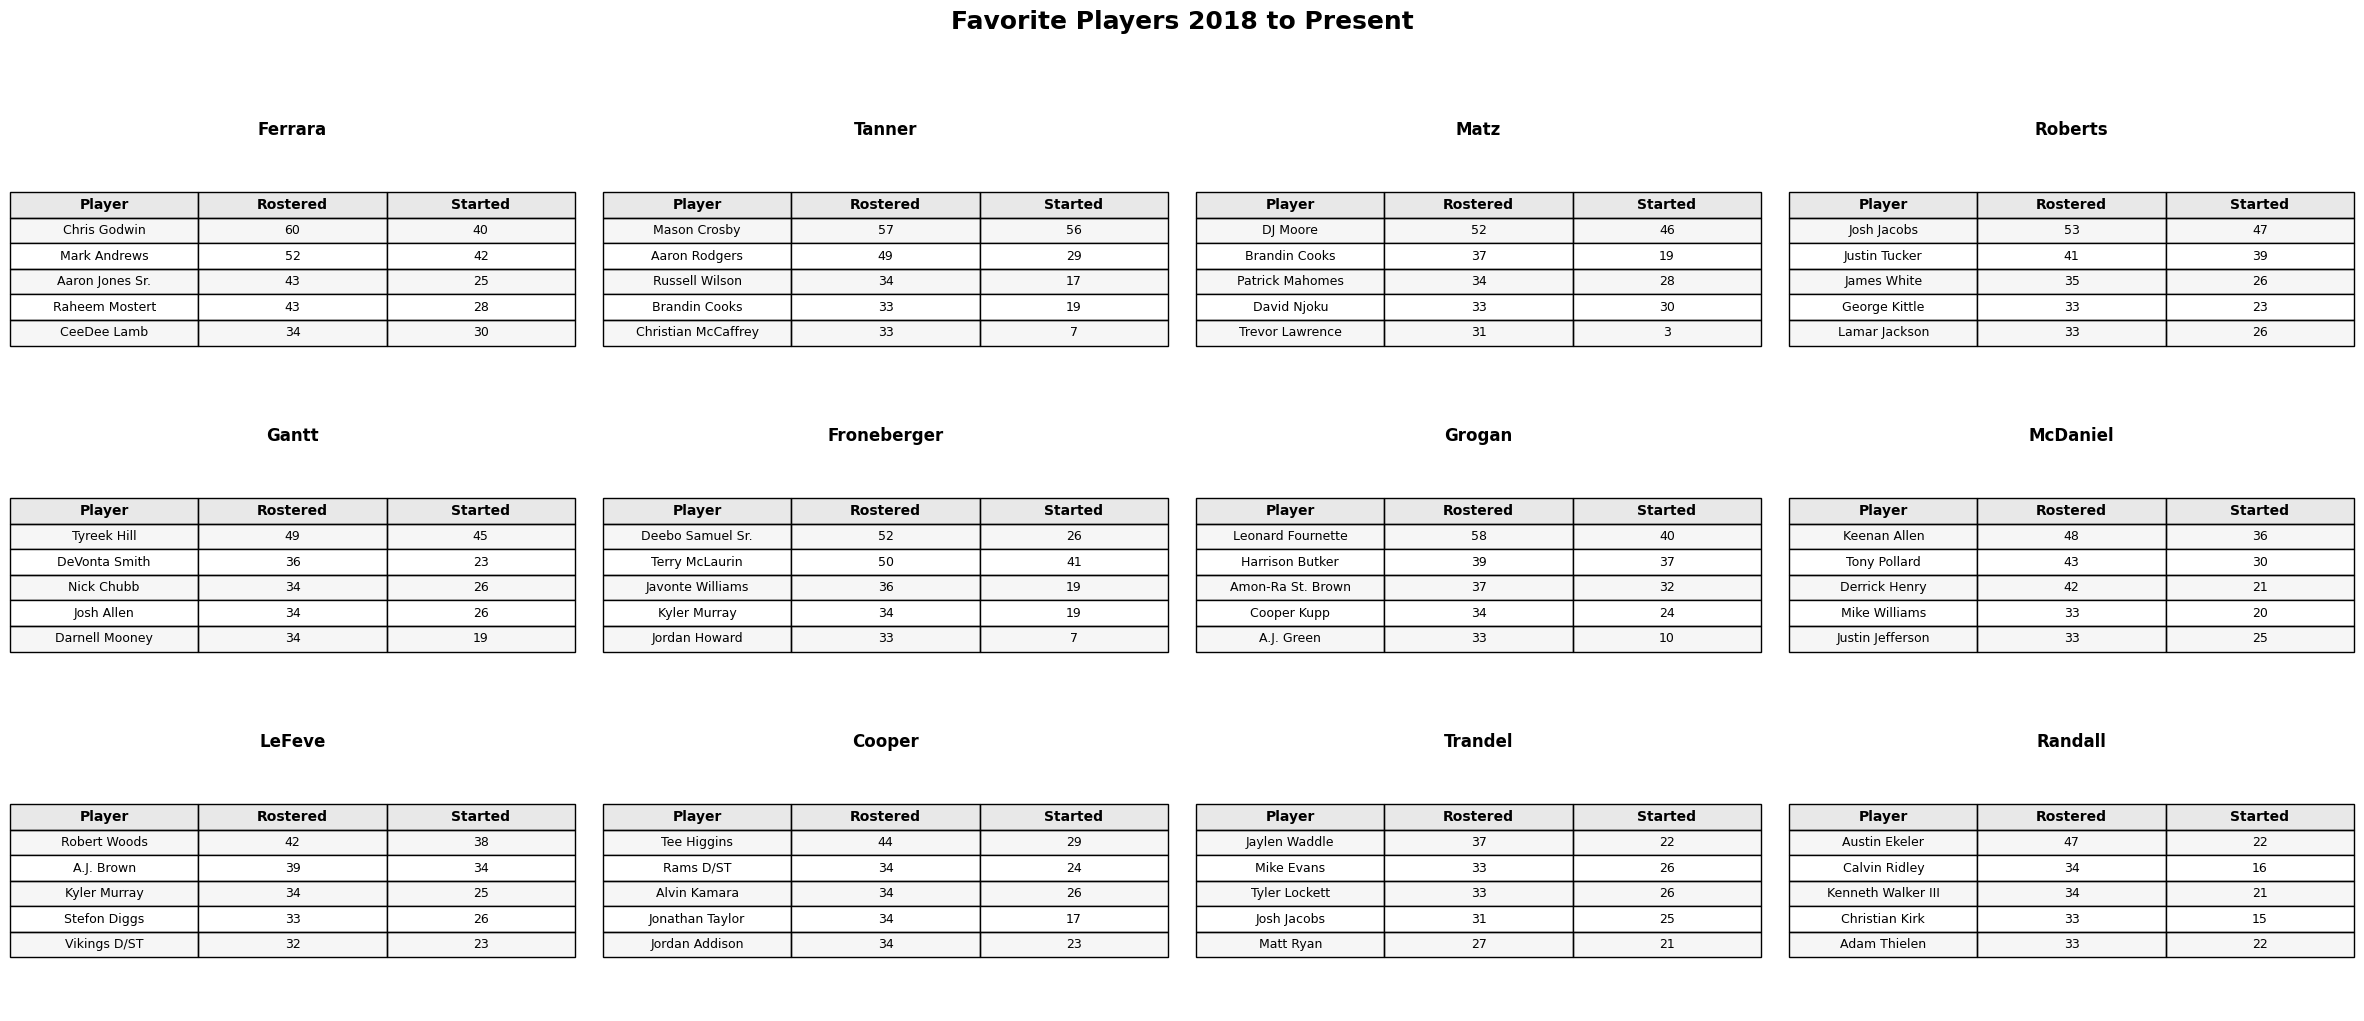

In [109]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from src.analysis import build_owner_lookup
from src.data import load_cache_entry

def grid_top_players(
    results,
    years,
    n=5,
    include_starters=True,
    league_title="Favorite Players 2018 to Present",
):
    """
    Display league-wide top players per owner in a grid of prettier tables.
    """
    latest_year = max(years)
    sample_data = load_cache_entry(LEAGUE_ID, latest_year, 1, ["mMatchup","mTeam"])
    owner_lookup = build_owner_lookup(sample_data)

    num_owners = len(results)
    cols = 4
    rows = (num_owners + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*3.5))
    axes = axes.flatten()

    # Add big league title
    fig.suptitle(league_title, fontsize=18, fontweight="bold", y=0.98)

    stripe_color = mcolors.to_rgba("lightgray", alpha=0.2)
    header_color = mcolors.to_rgba("lightgray", alpha=0.5)

    for idx, (team_id, (usage, names)) in enumerate(results.items()):
        ax = axes[idx]
        ax.axis("off")

        owner = owner_lookup.get(team_id, f"Team {team_id}")
        # Owner title, pulled *closer* to table
        ax.set_title(owner, fontsize=12, fontweight="bold", pad=2)

        headers = ["Player", "Rostered"]
        if include_starters:
            headers.append("Started")

        rows_data = []
        for pid, cnt in usage["rostered"].most_common(n):
            row = [names.get(pid, pid), cnt]
            if include_starters:
                row.append(usage["starters"][pid])
            rows_data.append(row)

        table = ax.table(
            cellText=rows_data,
            colLabels=headers,
            loc="center",
            cellLoc="center",
            colLoc="center",
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.4, 1.4)

        # Style headers + stripe rows
        for key, cell in table.get_celld().items():
            row, col = key
            if row == 0:
                cell.set_fontsize(10)
                cell.set_text_props(weight="bold")
                cell.set_facecolor(header_color)
            elif row % 2 == 1:
                cell.set_facecolor(stripe_color)

    # Hide unused slots
    for j in range(idx+1, len(axes)):
        axes[j].axis("off")

    # More breathing room around tables, but keep titles close
    plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.95])
    plt.show()



grid_top_players(res, years_to_check, n=5, include_starters=True)